In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.layers import Dense,Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC, BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import Sequential
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from sklearn.metrics import roc_curve, auc


In [8]:
image_size = (224, 224)
batch_size = 32

train_df = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/brain-stroke-prediction-ct-scan-image-dataset/Brain_Stroke_CT-SCAN_image/Train",
    image_size=image_size,
    batch_size=batch_size,
)
val_df = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/brain-stroke-prediction-ct-scan-image-dataset/Brain_Stroke_CT-SCAN_image/Validation",
    image_size=image_size,
    batch_size=batch_size,
)
test_df = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/brain-stroke-prediction-ct-scan-image-dataset/Brain_Stroke_CT-SCAN_image/Test",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False,   
)

Found 1843 files belonging to 2 classes.
Found 235 files belonging to 2 classes.
Found 437 files belonging to 2 classes.


In [9]:
y_true = np.concatenate([y for x, y in test_df], axis=0)

## Dense Net Model

In [22]:
base_model=tf.keras.applications.DenseNet121(input_shape=(224,224,3),include_top=False,weights='imagenet')
for layer in base_model.layers[400:]:
    layer.trainable = True

 
x = base_model.output     

x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid',name='Final')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss ='binary_crossentropy',optimizer='Adam',metrics=['accuracy',keras.metrics.Precision(),
                                                                       keras.metrics.Recall(), keras.metrics.SpecificityAtSensitivity(0.5),
                                                                       keras.metrics.SensitivityAtSpecificity(0.5)])

In [23]:
def get_callbacks(model_name):
    callbacks =[]

    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'model.{model_name}.keras', verbose=1, monitor='val_loss',mode='min',save_best_only=True)
    callbacks.append(checkpoint)
    anne = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=2, min_lr=0.0000001,min_delta=0.00001,mode='auto')
    callbacks.append(anne)
    earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    callbacks.append(earlystop)

    return callbacks

In [25]:
callbacks = get_callbacks('dense121')
history = model.fit( train_df,epochs=10,
                    validation_data= val_df,
                    callbacks=[callbacks])

Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9759 - loss: 0.0591 - precision_1: 0.9721 - recall_1: 0.9688 - sensitivity_at_specificity_1: 1.0000 - specificity_at_sensitivity_1: 1.0000
Epoch 1: val_loss improved from inf to 1.93875, saving model to model.dense121.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 222ms/step - accuracy: 0.9758 - loss: 0.0593 - precision_1: 0.9720 - recall_1: 0.9686 - sensitivity_at_specificity_1: 1.0000 - specificity_at_sensitivity_1: 1.0000 - val_accuracy: 0.7660 - val_loss: 1.9387 - val_precision_1: 1.0000 - val_recall_1: 0.2949 - val_sensitivity_at_specificity_1: 0.5641 - val_specificity_at_sensitivity_1: 1.0000 - learning_rate: 0.0010
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9760 - loss: 0.0675 - precision_1: 0.9761 - recall_1: 0.9660 - sensitivity_at_specificity_1: 1.0000 - specificity_at_sensitivity_1: 0.9987
Epoch 2: val_loss improved from 1.93875 to 0.24650, saving model to model.dense121.keras
58/58 ━━━━━━━━━━━━━━

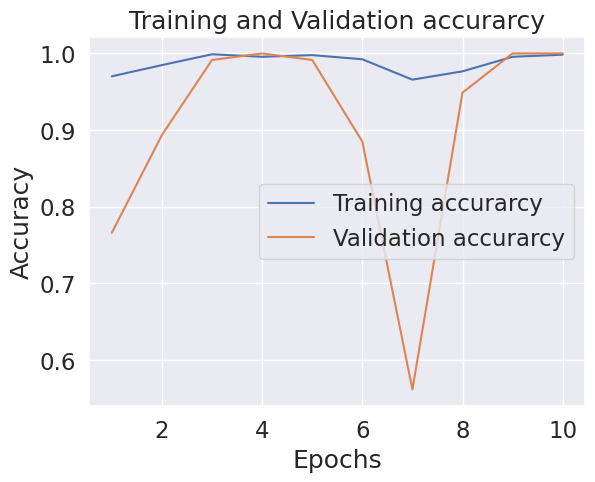

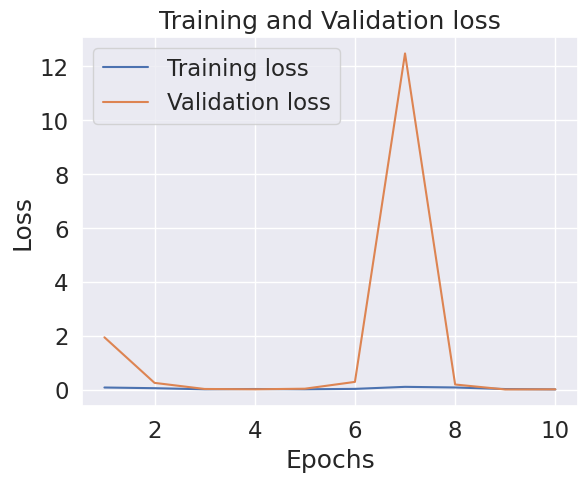

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, label='Training accurarcy')
plt.plot(epochs, val_acc, label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss,  label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
model = keras.models.load_model('model.dense121.keras')

In [28]:
results = model.evaluate(test_df, verbose=1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 381ms/step - accuracy: 0.9790 - loss: 0.0710 - precision_1: 0.3569 - recall_1: 0.4000 - sensitivity_at_specificity_1: 0.4000 - specificity_at_sensitivity_1: 0.3987       


In [29]:
y_pred = model.predict(test_df, verbose=1).round()   #  because we use sigmoid  >= 0.5 ? 1 , 0
y_pred = y_pred.flatten()

14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 558ms/step


              precision    recall  f1-score   support

      Normal     1.0000    0.9805    0.9901       307
      Stroke     0.9559    1.0000    0.9774       130

    accuracy                         0.9863       437
   macro avg     0.9779    0.9902    0.9838       437
weighted avg     0.9869    0.9863    0.9864       437



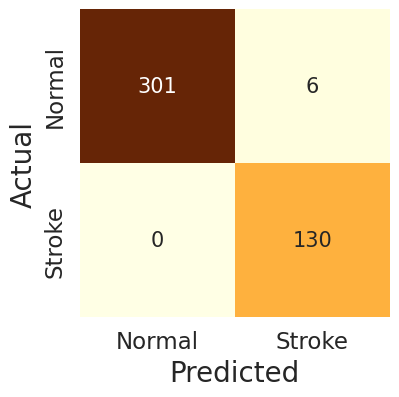

In [30]:
from sklearn.metrics import confusion_matrix
from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import classification_report
import seaborn as sn
import pandas as pd

target_names= ['Normal', 'Stroke']

report=classification_report(y_true, y_pred, target_names=target_names, digits=4)
print(report)


disp = confusion_matrix(y_true, y_pred)
disp.astype('int')
pd.options.display.float_format = '{:.5f}'.format
df_cm = pd.DataFrame(disp, target_names, target_names)
# plt.figure(figsize=(10,7))
fig, ax = plt.subplots(figsize=(4,4))
sn.set(font_scale=1.5) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 15},ax=ax, cmap="YlOrBr" , fmt='g',cbar=False) # font size
plt.ylabel('Actual',fontsize=20)
plt.xlabel('Predicted',fontsize=20)
plt.ioff()
plt.savefig("confusion_mat", bbox_inches='tight')
plt.show()
